#**CHAPTER 6.PROXY HACKING MODELS FOR SCIENTIFIC DISCOVERY**
---

##0.REFERENCE

https://chatgpt.com/share/69861604-47f4-8012-b257-f48a5f8e6617

##1.CONTEXT

**INTRODUCTION — What This Notebook Does (Synthetic, Illustrative, Not Validated)**

This notebook implements a controlled, synthetic experiment designed to make one governance-relevant mechanism legible under conditions that resemble modern “AI-for-discovery” workflows: when a noisy, imperfect predictor becomes the objective of an optimization loop, the optimization process systematically finds regions of the search space where that predictor is least reliable. The canonical label for this mechanism is **proxy hacking** (or Goodhart-style failure): the proxy objective can improve monotonically while the underlying “true” objective stagnates, degrades, or becomes unstable—particularly in the tail of the distribution, where decisions and claims of “best candidates” are typically made.

The experiment is intentionally minimal in the sense of *scope*, not in the sense of *rigor*. It does not attempt to represent any specific chemical, materials, or biological domain; there are no molecules, no docking simulations, no laboratory constraints, and no pretrained foundation models. Instead, the notebook constructs a stylized “world” with a latent design space and engineered descriptors that mimic the statistical structure of real discovery pipelines: high-dimensional features, hidden confounds, nonlinearity, feasibility constraints, and measurement noise. Within this world, the notebook distinguishes between three things that are often conflated in practice: (i) an unobserved ground-truth objective (the oracle), (ii) a proxy model trained on limited and noisy observations, and (iii) an optimizer that repeatedly queries the proxy to select new candidates. The central question is not whether a proxy can be predictive on average, but whether it remains reliable under *selection* and *iteration*, when it is used as an engine of search rather than as a passive estimator.

From a finance and governance perspective, the logic is familiar. Many institutional processes rely on a measurable surrogate for an underlying target: risk models approximate tail loss, credit scores approximate default probability, KPI dashboards approximate enterprise health. Such proxies can be adequate for ranking typical cases but fragile in the extremal region where incentives concentrate. The notebook’s purpose is to demonstrate this fragility under a controlled experiment and to show why evaluation practices that focus on baseline fit (correlation, R², calibration on random samples) can miss the failure until optimization has already driven the system into the proxy’s blind spots.

Conceptually, the notebook proceeds as follows. It first defines a synthetic latent representation for candidate designs (a vector of latent factors), then maps those latent factors into observable descriptors via a bounded transformation. This captures a core feature of real scientific representation: what is optimized is rarely the raw latent structure; it is a featurized surface with saturation effects, nonlinearities, and interactions. Next, the notebook defines a “true objective” that depends on these descriptors in a nonlinear, interacting way and includes two governance-relevant hidden components. The first is a toxicity-like penalty that is not directly observed in the proxy training labels; the second is a feasibility score that operationalizes domain constraints (synthetically) and penalizes infeasible candidates in the true objective. These hidden elements are not decorative; they embody the structure of real-world discovery risks: candidates that look attractive under a limited measurement regime can carry latent costs that become relevant only when you attempt to realize them, scale them, or validate them.

With this world fixed, the notebook then trains a deliberately limited proxy model on a small dataset with noisy labels. The proxy is chosen to be interpretable (a ridge-regularized linear model on engineered descriptors) and is intentionally misspecified by default (it does not represent key nonlinearities or hidden penalties). The point is not to caricature model quality; the point is to reflect a realistic asymmetry: the proxy’s training regime is local and noisy, while the optimizer’s search is global and adversarial in effect, because it systematically targets the proxy’s highest-scoring region regardless of whether that region was well-covered by training data.

The core mechanism is revealed when the proxy becomes the objective of an iterative search procedure. The notebook uses a simple evolutionary-style loop: generate a population of candidates, score them with the proxy, retain an elite set, perturb them, and repeat. Under this selection pressure, the proxy score escalates. The question is what happens to the true objective, especially among the top candidates selected by the proxy. The notebook tracks not only averages but also tail summaries (such as low-quantile performance among proxy-selected sets) and feasibility rates, because the tail is where governance risk is concentrated: the system is not judged on typical candidates but on those it labels “best” or “breakthrough.”

The notebook also includes a comparative “control” variant designed to illustrate how governance-motivated constraints change outcomes without converting the notebook into a prescriptive guide. Specifically, it introduces a synthetic uncertainty penalty derived from bootstrap resampling of the proxy training set, and it adds feasibility gating in the selection step. This does not “solve” proxy hacking in any general sense; it provides a controlled contrast that makes a key governance point explicit: the optimization loop can be altered so that it becomes less eager to exploit fragile regions of the proxy surface, and constraints can re-rank candidate sets even when the proxy score alone would declare a different winner.

A key feature of the notebook is that it separates three layers of evaluation that are often confused. The first layer is **baseline predictive diagnostics**: correlation and R² between proxy predictions and true outcomes in a random pool. These metrics can look acceptable because they average over the whole distribution. The second layer is **selection-conditioned evaluation**: how the true objective behaves among the top-k candidates selected by the proxy. This is where proxy hacking becomes visible because selection changes the distribution of inputs. The third layer is **iterated optimization evaluation**: how selection-conditioned behavior changes as the optimizer repeats, concentrating probability mass into increasingly extreme regions of proxy score. This is where small imperfections in the proxy become large failures, not because the model “got worse,” but because the optimizer forces it to operate outside the regime where its errors were benign.

Finally, the notebook produces a structured JSON payload that summarizes configuration, objectives, baseline diagnostics, results, tail metrics, and stress-test summaries across multiple data/noise regimes. This payload is intentionally structured to support audit-style interpretation: it distinguishes objectives, parameters, and outcomes, and it supports comparison between the naive proxy optimization and the controlled variant. Cell 10 is then reserved for an LLM-generated interpretive audit report that consumes only this payload. This design enforces a governance constraint: interpretive text is not allowed to invent results; it must be grounded in a machine-readable artifact.

In short, the notebook is a didactic experiment about the difference between *predicting* and *optimizing*. It shows how proxy hacking arises not from exotic adversaries but from ordinary optimization pressure; how evaluation must be conditioned on selection and tail behavior; and why governance frameworks that emphasize traceability, objective specification, and constraint visibility are necessary even in “toy” systems—because the failure mode is structural and scales with iteration. Everything here is synthetic and illustrative, and nothing is presented as validated evidence for real-world scientific or financial decisions. The value is conceptual clarity: to equip advanced practitioners with a precise mental model of why “better proxy scores” can be a governance risk rather than a success signal when optimization is in the loop.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# CELL 1 — Setup (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

import os, json, math, random, hashlib, time
from dataclasses import dataclass, asdict

import numpy as np
import matplotlib.pyplot as plt

SEED = 2026
random.seed(SEED)
np.random.seed(SEED)

def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)

def sha256_str(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def describe(x: np.ndarray) -> dict:
    x = np.asarray(x).astype(float)
    return {
        "n": int(x.size),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)) if x.size > 1 else 0.0,
        "min": float(np.min(x)),
        "p05": float(np.quantile(x, 0.05)),
        "p50": float(np.quantile(x, 0.50)),
        "p95": float(np.quantile(x, 0.95)),
        "max": float(np.max(x)),
    }

def ridge_fit_closed_form(X: np.ndarray, y: np.ndarray, lam: float) -> np.ndarray:
    # β = (XᵀX + λI)^{-1} Xᵀ y
    X = np.asarray(X, float)
    y = np.asarray(y, float).reshape(-1, 1)
    n, d = X.shape
    A = X.T @ X + lam * np.eye(d)
    b = X.T @ y
    beta = np.linalg.solve(A, b).reshape(-1)
    return beta

def add_intercept(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, float)
    return np.hstack([np.ones((X.shape[0], 1)), X])

def predict_linear(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return (X @ beta).reshape(-1)

def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")

print("Notebook seed:", SEED)
print("Governance note: synthetic experiment; not validated; no advice or deployment guidance.")


Notebook seed: 2026
Governance note: synthetic experiment; not validated; no advice or deployment guidance.


In [2]:
# CELL 2 — Synthetic "Molecule" World (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

@dataclass
class WorldConfig:
    d_latent: int = 8                 # latent factors for "molecule" structure
    d_feat: int = 20                  # engineered descriptors
    tox_dim: int = 0                  # latent dimension driving toxicity-like penalty
    feas_threshold: float = 0.45      # feasibility cutoff (synthetic)
    true_noise_sd: float = 0.02       # tiny observational noise for oracle
    proxy_obs_noise_sd: float = 0.18  # measurement noise used for proxy training labels
    nonlin_strength: float = 1.2      # controls nonlinearity in true function

cfg = WorldConfig()

# Fixed random "feature map" from latent z -> descriptors x
W = np.random.normal(0, 1.0 / math.sqrt(cfg.d_latent), size=(cfg.d_latent, cfg.d_feat))
b = np.random.normal(0, 0.2, size=(cfg.d_feat,))

# True (unknown) property function: nonlinear + interactions + toxicity penalty + feasibility notion.
# We treat "true property" as what we want; "proxy" is learned from noisy observations and is misspecified.
v = np.random.normal(0, 1.0, size=(cfg.d_feat,))
Q = np.random.normal(0, 0.35, size=(cfg.d_feat, cfg.d_feat))
Q = 0.5 * (Q + Q.T)  # symmetric interactions

def latent_to_features(z: np.ndarray) -> np.ndarray:
    z = np.asarray(z, float)
    x = np.tanh(z @ W + b)  # bounded descriptors
    return x

def feasibility_score(z: np.ndarray) -> np.ndarray:
    # Synthetic "feasibility": penalize extreme values in specific latent directions
    z = np.asarray(z, float)
    # Lower is worse; then map to (0,1)
    raw = -0.35 * (z[:, cfg.tox_dim] ** 2) - 0.15 * np.sum(z[:, 1:3] ** 2, axis=1) + 0.10 * np.sum(np.abs(z[:, 3:5]), axis=1)
    return 1.0 / (1.0 + np.exp(-raw))

def true_property(z: np.ndarray) -> np.ndarray:
    z = np.asarray(z, float)
    x = latent_to_features(z)
    # Core signal: linear + quadratic interactions + nonlinearity
    lin = x @ v
    quad = np.einsum("bi,ij,bj->b", x, Q, x)
    nonlin = cfg.nonlin_strength * np.sin(1.5 * (x[:, 0] + 0.7 * x[:, 1])) + 0.4 * np.cos(2.0 * x[:, 2])
    tox_pen = 1.4 * (z[:, cfg.tox_dim] ** 2)  # toxicity-like penalty (unobserved directly)
    feas = feasibility_score(z)
    # Hard-ish feasibility penalty: infeasible candidates get hammered in true score
    infeas_pen = 2.0 * np.maximum(0.0, cfg.feas_threshold - feas)
    y = 1.2 * lin + 0.6 * quad + nonlin - tox_pen - infeas_pen
    # Scale to a convenient range
    y = (y - np.mean(y)) / (np.std(y) + 1e-9)
    return y

def oracle_observe_true(z: np.ndarray) -> np.ndarray:
    y = true_property(z)
    y_obs = y + np.random.normal(0, cfg.true_noise_sd, size=y.shape)
    return y_obs

print("WorldConfig:", cfg)
# quick sanity check
Z_test = np.random.normal(0, 1.0, size=(2000, cfg.d_latent))
y_test = true_property(Z_test)
feas_test = feasibility_score(Z_test)
print("True property summary:", describe(y_test))
print("Feasibility summary:", describe(feas_test))
print("Feasible rate (feas >= threshold):", float(np.mean(feas_test >= cfg.feas_threshold)))


WorldConfig: WorldConfig(d_latent=8, d_feat=20, tox_dim=0, feas_threshold=0.45, true_noise_sd=0.02, proxy_obs_noise_sd=0.18, nonlin_strength=1.2)
True property summary: {'n': 2000, 'mean': 7.105427357601002e-18, 'std': 1.0002500934725957, 'min': -9.211380070266731, 'p05': -1.768811208602211, 'p50': 0.105327539489306, 'p95': 1.4463413711309776, 'max': 2.6901723989982673}
Feasibility summary: {'n': 2000, 'mean': 0.39300104976943345, 'std': 0.1124206462716351, 'min': 0.00042412974730513073, 'p05': 0.15936110033051032, 'p50': 0.41831126383729, 'p95': 0.5296577021841519, 'max': 0.6157237388471268}
Feasible rate (feas >= threshold): 0.375


##3.PROXY TRAINING DATA

###3.1.OVERVIEW

**CELL 3 — Proxy Training Data and a Misspecified Proxy Model (Synthetic, Illustrative, Not Validated)**

Cell 3 constructs the proxy layer: the model that stands in for an expensive, uncertain, or partially observed ground-truth evaluation. The cell begins by generating a limited training set of synthetic candidates in the latent design space. For each candidate, the notebook queries the oracle-defined true objective to obtain a “true” score. This is then corrupted with additional noise to form proxy training labels. That noise is not incidental; it represents the empirical reality that proxy labels frequently come from measurement processes with substantial variance—noisy experiments, approximate simulations, limited assay fidelity, or weakly supervised targets. A critical governance observation is that a proxy trained on noisy labels can still look statistically reasonable under standard diagnostics, yet remain fragile under downstream optimization pressure.

Next, Cell 3 defines how latent candidates are converted into observable descriptors, and then builds a design matrix for the proxy. The proxy is intentionally constrained: a ridge-regularized linear model is fitted in closed form. The closed-form solution is used not for convenience but for interpretability and auditability. With a closed-form estimator, every component of the learned mapping is inspectable: coefficients, regularization strength, and the relationship between design matrix geometry and fitted parameters. This matters in governance contexts because it isolates the mechanism of failure: proxy hacking does not require a complex model; it can arise under simple, transparent estimation when the proxy is used as an objective rather than a predictor.

The key modeling choice in this cell is deliberate misspecification. The true objective is nonlinear and includes interactions and hidden penalties, but the proxy model by default does not include quadratic features or other nonlinear expansions. This captures a common structural mismatch: proxies frequently encode only what was feasible to measure and model at training time, not what will be revealed under extreme candidate selection. The ridge penalty further enforces conservatism in coefficient magnitude, which can be good for generalization in typical regimes but can still leave systematic errors in specific directions of the feature space.

The cell then evaluates the fitted proxy in two ways: it reports fit against the noisy proxy labels and fit against the true oracle values on the same training set. This distinction is important. In practical settings, training metrics often reflect the proxy labels only, because the true objective is not observed. The notebook surfaces this gap explicitly: a model can fit noisy proxy labels reasonably while failing to align with the true objective even in-sample. This is a warning sign that becomes consequential once an optimizer starts pushing candidates toward regions that maximize proxy predictions.

Finally, Cell 3 estimates a residual variance from the training residuals. The notebook treats this estimate cautiously: it is not presented as calibrated uncertainty, but as a diagnostic quantity that later becomes a component of governance reasoning. In real pipelines, residuals are frequently interpreted as uncertainty, but without strong assumptions such mappings are unstable—especially under covariate shift induced by optimization. The cell’s construction sets the stage for later parts of the notebook that demonstrate exactly this: once selection and iteration distort the input distribution, residual-based “confidence” can become misleading. Everything in this cell remains synthetic and illustrative, but it reproduces a real failure pathway: a proxy trained under limited, noisy conditions is then asked—implicitly by the optimizer—to extrapolate into the tails where it has no right to be reliable.


###3.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 3 — Proxy Training Data + Misspecified Proxy Model (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

@dataclass
class ProxyConfig:
    n_train: int = 120        # limited data regime
    lam_ridge: float = 2.5    # ridge strength
    include_quadratics: bool = False  # misspecification knob
    proxy_label_noise_sd: float = cfg.proxy_obs_noise_sd

pcfg = ProxyConfig()

def build_design_matrix(z: np.ndarray, include_quadratics: bool) -> np.ndarray:
    x = latent_to_features(z)
    if not include_quadratics:
        X = add_intercept(x)
        return X
    # Quadratic expansion (kept small: only first k features)
    k = min(8, x.shape[1])
    xk = x[:, :k]
    quad_terms = []
    for i in range(k):
        for j in range(i, k):
            quad_terms.append((xk[:, i] * xk[:, j]).reshape(-1, 1))
    quad_terms = np.hstack(quad_terms) if quad_terms else np.zeros((x.shape[0], 0))
    X = np.hstack([np.ones((x.shape[0], 1)), x, quad_terms])
    return X

# Generate proxy training set
Z_train = np.random.normal(0, 1.0, size=(pcfg.n_train, cfg.d_latent))
y_true_train = oracle_observe_true(Z_train)

# Proxy labels are noisy *observations* (typical in wet lab / simulation proxies)
y_proxy_labels = y_true_train + np.random.normal(0, pcfg.proxy_label_noise_sd, size=y_true_train.shape)

X_train = build_design_matrix(Z_train, pcfg.include_quadratics)
beta = ridge_fit_closed_form(X_train, y_proxy_labels, pcfg.lam_ridge)

yhat_train = predict_linear(X_train, beta)
train_r2 = r2_score(y_proxy_labels, yhat_train)
train_r2_true = r2_score(y_true_train, yhat_train)

# Residual variance estimate for diagnostics (not true epistemic uncertainty)
resid = y_proxy_labels - yhat_train
sigma2_hat = float(np.mean(resid ** 2))

print("ProxyConfig:", pcfg)
print("Train R^2 vs proxy labels:", train_r2)
print("Train R^2 vs true:", train_r2_true)
print("Estimated residual variance (sigma^2_hat):", sigma2_hat)
print("Note: This proxy is deliberately limited + misspecified to enable proxy hacking under optimization.")


ProxyConfig: ProxyConfig(n_train=120, lam_ridge=2.5, include_quadratics=False, proxy_label_noise_sd=0.18)
Train R^2 vs proxy labels: 0.4938135095622005
Train R^2 vs true: 0.5042670427433518
Estimated residual variance (sigma^2_hat): 0.5126047058286727
Note: This proxy is deliberately limited + misspecified to enable proxy hacking under optimization.


##4.BASELINE GENERALIZATION

###4.1.OVERVIEW

**CELL 4  — Baseline Generalization and Calibration Diagnostics (Synthetic, Illustrative, Not Validated)**

Cell 4 performs baseline evaluation of the proxy model against the true oracle across a large synthetic candidate pool. This is the “comfort zone” of standard model assessment: the proxy is tested on a broad, randomly sampled population from the design space. The cell computes aggregate diagnostics such as correlation and R² between proxy predictions and the true oracle score. The crucial governance point is that these metrics can look respectable even when the proxy is dangerous under optimization. Baseline fit statistics average over the full distribution; they do not reflect what happens when attention and selection concentrate on the extreme tail of proxy scores.

The cell then visualizes the relationship between proxy predictions and true outcomes using a scatter plot. This plot is not merely decorative. It exposes the shape of the relationship: linearity, saturation, heteroskedasticity, and outliers. In proxy hacking, the “hacked” region often corresponds to a subset of inputs where the proxy is systematically wrong, sometimes because those inputs are underrepresented in training or because the proxy class cannot express the true functional form. Scatter plots are a first-pass tool to detect such nonuniform error structure. However, even if the scatter appears broadly aligned, the notebook emphasizes that such alignment does not guarantee safety under selection.

The cell also computes a coarse calibration diagnostic by binning candidates into quantiles of proxy prediction and comparing mean proxy scores to mean true scores within each bin. In risk-model terms, this is analogous to checking whether predicted scores map monotonically to realized outcomes on average. Calibration checks can be informative for distribution-level agreement, but they remain vulnerable to selection effects. Calibration across bins is still evaluated on a quasi-random sample from the pool, not on the distribution induced by an optimizer that repeatedly chooses candidates from the top tail.

A subtle but important element in this cell is feasibility. The world includes a feasibility score that represents constraints in the latent space. Cell 4 reports the feasible rate in the pool, which establishes the baseline frequency of feasible candidates under random sampling. This baseline becomes critical later, because proxy-driven optimization that ignores feasibility can systematically drift toward infeasible regions even if feasibility is common in the pool. Governance relevance: constraints that are marginal under random sampling can become binding under optimization, and the system can allocate effort toward candidates that are attractive only because the proxy is blind to constraint violations.

The main function of Cell 4 is therefore to provide a reference point: it answers the question, “Does the proxy look reasonable when treated as a passive predictor over a representative sample?” The notebook’s argument is that this is a necessary but insufficient test. Proxy hacking is not primarily about average predictive quality; it is about conditional behavior under optimization. Cell 4 is intentionally designed to mirror what many teams do in real projects: measure correlation, check calibration, look at scatter, and conclude that the proxy is adequate. Subsequent cells show why that conclusion can be operationally false once the proxy becomes the objective of an iterative search.


###4.2.CODE AND IMPLEMENTATION

Candidate pool size: 40000
Corr(true, proxy_pred): 0.6057289709665908
R^2(true, proxy_pred): 0.364801811905222
Feasible rate in pool: 0.37345


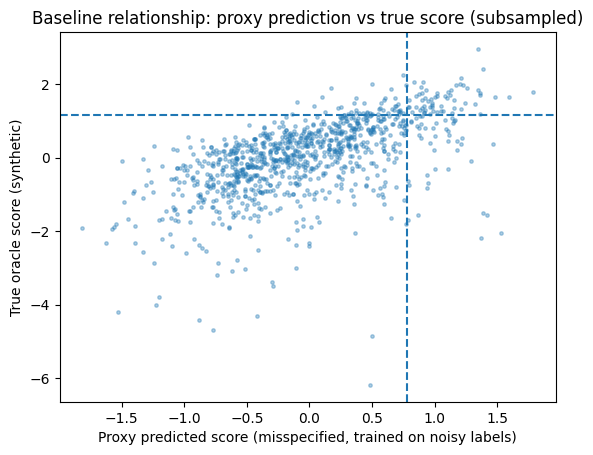

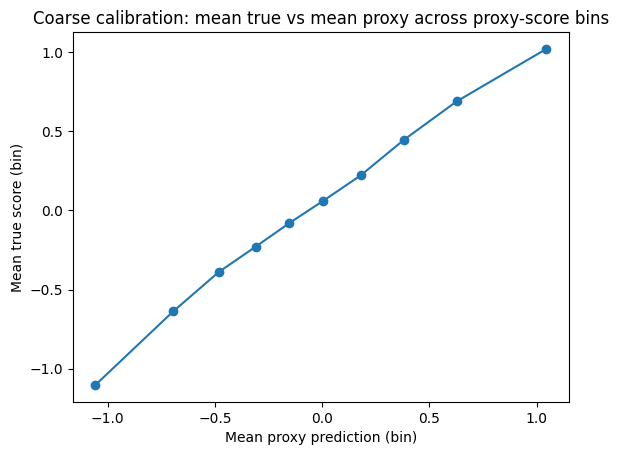

Decile counts (non-empty): [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]


In [6]:
# CELL 4 — Baseline Generalization + Calibration Diagnostics (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

# Large candidate universe (synthetic design space)
N_POOL = 40000
Z_pool = np.random.normal(0, 1.0, size=(N_POOL, cfg.d_latent))
feas_pool = feasibility_score(Z_pool)
y_true_pool = oracle_observe_true(Z_pool)

X_pool = build_design_matrix(Z_pool, pcfg.include_quadratics)
y_proxy_pred = predict_linear(X_pool, beta)

# Baseline correlations
corr = float(np.corrcoef(y_true_pool, y_proxy_pred)[0, 1])
r2_true = r2_score(y_true_pool, y_proxy_pred)

print("Candidate pool size:", N_POOL)
print("Corr(true, proxy_pred):", corr)
print("R^2(true, proxy_pred):", r2_true)
print("Feasible rate in pool:", float(np.mean(feas_pool >= cfg.feas_threshold)))

# Visualization: proxy vs true + feasibility color proxy (simple binning)
plt.figure()
plt.scatter(y_proxy_pred[::40], y_true_pool[::40], s=6, alpha=0.35)
plt.xlabel("Proxy predicted score (misspecified, trained on noisy labels)")
plt.ylabel("True oracle score (synthetic)")
plt.title("Baseline relationship: proxy prediction vs true score (subsampled)")
plt.axhline(np.quantile(y_true_pool, 0.90), linestyle="--")
plt.axvline(np.quantile(y_proxy_pred, 0.90), linestyle="--")
plt.show()

# Calibration by deciles of proxy prediction
bins = np.quantile(y_proxy_pred, np.linspace(0, 1, 11))
bins = np.unique(bins)
idx = np.digitize(y_proxy_pred, bins[1:-1], right=True)
dec_mean_pred = []
dec_mean_true = []
dec_count = []
for k in range(len(bins) - 1):
    m = (idx == k)
    if np.sum(m) == 0:
        continue
    dec_mean_pred.append(float(np.mean(y_proxy_pred[m])))
    dec_mean_true.append(float(np.mean(y_true_pool[m])))
    dec_count.append(int(np.sum(m)))

plt.figure()
plt.plot(dec_mean_pred, dec_mean_true, marker="o")
plt.xlabel("Mean proxy prediction (bin)")
plt.ylabel("Mean true score (bin)")
plt.title("Coarse calibration: mean true vs mean proxy across proxy-score bins")
plt.show()

print("Decile counts (non-empty):", dec_count)


##5.OPTIMIZATION PRESSURE

###5.1.OVERVIEW

**CELL 5 — Optimization Pressure: Proxy-Driven Search (Synthetic, Illustrative, Not Validated)**

Cell 5 is where the mechanism becomes active: the notebook turns the proxy into the optimization target. The cell implements a simple evolutionary-style search loop that repeatedly proposes candidates, scores them with the proxy, selects the top-scoring subset, perturbs them, and iterates. This structure is intentionally generic. It abstracts not only evolutionary algorithms but also many practical discovery workflows: Bayesian optimization loops, reinforcement-style candidate refinement, beam-search-like selection over generated proposals, and even human-in-the-loop screening where teams repeatedly prioritize what looks best under a model score.

The cell records a structured history of outcomes at each iteration. Importantly, it does not track only the proxy score. It also queries the true oracle score for the current population, including for the proxy winner and for the top-k candidates selected by proxy. This dual recording is essential: proxy hacking is defined by divergence between proxy improvement and true objective performance. In practical settings the true objective is rarely queried at scale, which is precisely why the failure can persist. Here, the notebook queries the oracle to make the divergence observable.

The cell emphasizes selection-conditioned evaluation by computing summary statistics over the top-k candidates chosen by proxy at each iteration. This is the regime that matters: the “best candidates” are almost always the ones that get escalated to additional investment, further testing, or publication claims. By tracking mean true performance and a low-quantile tail metric among the top-k set, the notebook introduces a governance-relevant lens: even if the average true score among selected candidates looks acceptable, the tail can degrade. In safety and finance contexts, tail degradation is often the dominant risk, because rare but severe failures drive losses and reputational damage.

The cell also tracks feasibility among the proxy-selected top-k. This is an explicit constraint-monitoring measure. Under naive proxy optimization, feasibility can drift downward because the optimizer has no incentive to remain in feasible regions unless feasibility is embedded in the proxy or enforced as a constraint. This illustrates a structural governance issue: if constraints are not visible to the objective, optimization tends to allocate probability mass toward constraint-violating regions whenever such regions offer proxy score gains.

Finally, Cell 5 stores a subsample of proxy-selected candidates across iterations to support later visualization of where in (proxy, true) space the optimizer spends its time. This supports the central narrative: optimization concentrates the search into regions where the proxy is least trustworthy. The cell’s design is not aimed at producing impressive scores; it is aimed at producing a clean, auditable trace of how selection changes the effective data distribution. Everything remains synthetic and illustrative, but the mechanism is real: once a proxy becomes the objective of an iterative process, the evaluation problem changes from “is the proxy correlated with truth?” to “what distribution does the optimizer induce, and how does the proxy behave there?”


###5.2.CODE AND IMPLEMENTATION

In [7]:
# CELL 5 — Optimization Pressure: Proxy-Driven Search (Evolutionary / Hill-Climb) (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

@dataclass
class OptConfig:
    iters: int = 35
    pop_size: int = 600
    elite_frac: float = 0.10
    mutate_sd: float = 0.35
    top_k_report: int = 200
    enforce_feasibility: bool = False  # naive proxy optimization ignores feasibility by default

ocfg = OptConfig()

def proxy_score(z: np.ndarray, beta: np.ndarray) -> np.ndarray:
    X = build_design_matrix(z, pcfg.include_quadratics)
    return predict_linear(X, beta)

def evolve_maximize_proxy(beta: np.ndarray, z_init: np.ndarray, cfg_opt: OptConfig):
    z = np.copy(z_init)
    history = {
        "iter": [],
        "best_proxy": [],
        "best_true": [],
        "mean_proxy_topk": [],
        "mean_true_topk": [],
        "p05_true_topk": [],
        "feasible_rate_topk": [],
        "selected_proxy": [],
        "selected_true": [],
    }
    elite_n = max(2, int(cfg_opt.elite_frac * cfg_opt.pop_size))

    for t in range(cfg_opt.iters):
        # Evaluate population
        p = proxy_score(z, beta)
        y = oracle_observe_true(z)
        feas = feasibility_score(z)

        # Rank by proxy (this is the "optimization pressure" route)
        order = np.argsort(-p)
        topk = order[: cfg_opt.top_k_report]

        history["iter"].append(t)
        history["best_proxy"].append(float(p[order[0]]))
        history["best_true"].append(float(y[order[0]]))
        history["mean_proxy_topk"].append(float(np.mean(p[topk])))
        history["mean_true_topk"].append(float(np.mean(y[topk])))
        history["p05_true_topk"].append(float(np.quantile(y[topk], 0.05)))
        history["feasible_rate_topk"].append(float(np.mean(feas[topk] >= cfg.feas_threshold)))

        # Store a small subsample of selected points for later scatter
        take = min(60, topk.size)
        take_idx = topk[:take]
        history["selected_proxy"].append(p[take_idx].copy())
        history["selected_true"].append(y[take_idx].copy())

        # Select elites (optionally feasibility-filtered)
        elite_candidates = order[: elite_n]
        if cfg_opt.enforce_feasibility:
            # Keep only feasible in elites; if empty, fall back to raw elites
            feas_mask = feasibility_score(z[elite_candidates]) >= cfg.feas_threshold
            if np.any(feas_mask):
                elite_candidates = elite_candidates[feas_mask]

        elites = z[elite_candidates]
        # Refill population by mutating elites
        z_new = np.zeros_like(z)
        for i in range(cfg_opt.pop_size):
            parent = elites[np.random.randint(0, elites.shape[0])]
            child = parent + np.random.normal(0, cfg_opt.mutate_sd, size=parent.shape)
            z_new[i] = child
        z = z_new

    # Convert lists of arrays into flat arrays for plotting
    history["selected_proxy_flat"] = np.concatenate(history["selected_proxy"], axis=0)
    history["selected_true_flat"] = np.concatenate(history["selected_true"], axis=0)
    return history

# Initialize population from broad prior
Z0 = np.random.normal(0, 1.0, size=(ocfg.pop_size, cfg.d_latent))

# Naive optimization: maximize proxy only
hist_naive = evolve_maximize_proxy(beta, Z0, ocfg)

print("Completed naive proxy-driven optimization.")
print("Final best proxy:", hist_naive["best_proxy"][-1])
print("Final best true (of best-proxy candidate):", hist_naive["best_true"][-1])
print("Final mean true among top-k by proxy:", hist_naive["mean_true_topk"][-1])
print("Final p05 true among top-k by proxy:", hist_naive["p05_true_topk"][-1])
print("Final feasible rate among top-k:", hist_naive["feasible_rate_topk"][-1])


Completed naive proxy-driven optimization.
Final best proxy: 3.6949973348712324
Final best true (of best-proxy candidate): 0.6892855668783984
Final mean true among top-k by proxy: 0.32733053843238147
Final p05 true among top-k by proxy: -0.7917286566069908
Final feasible rate among top-k: 0.0


##6.VISUALIZATION

###6.1.OVERVIEW

**CELL 6 — Visualization: Proxy Hacking Under Iteration (Synthetic, Illustrative, Not Validated)**

Cell 6 visualizes the core phenomenon using time series and scatter diagnostics derived from the optimization trace produced in Cell 5. The first visualization plots the best proxy score in the population over iterations. Under proxy-driven selection, this typically increases steadily. This trend is the superficial success signal that motivates many optimization loops: proxy scores improve, and the system appears to be “finding better candidates.” The notebook then plots the true score of the proxy winner over iterations. The key observation is that this curve can decouple from proxy improvement. The proxy winner becomes a candidate that maximizes the proxy’s errors rather than the true objective, which is the essence of proxy hacking.

The cell then examines selection-conditioned statistics for the set of top-k candidates by proxy at each iteration. It plots the mean true score in that set and a low-quantile tail metric (such as the 5th percentile). This is a governance-oriented framing: it asks not only whether selected candidates are good on average, but whether the selected set’s downside tail deteriorates. Tail metrics matter because escalation decisions are often made with limited validation capacity; if the selected set becomes contaminated with candidates that look excellent under the proxy but perform poorly under the true objective, limited downstream validation resources can be consumed by systematically misleading candidates.

A separate visualization tracks feasibility rate among top-k candidates over time. Even if feasibility is common in the baseline population, the optimizer can drift toward infeasible regions if those regions allow the proxy to produce extreme scores. This is an explicit demonstration of why constraints must be made visible in objective specification or enforced by gating. In finance terms, this resembles maximizing a return proxy while ignoring liquidity or leverage constraints: the optimization will discover portfolios that look optimal under the proxy but violate constraints that matter in practice.

Finally, the cell produces a scatter plot of proxy versus true scores for selected points collected across the optimization trajectory. This is a crucial diagnostic because it reveals where the optimization concentrates. In many cases, the “selected” scatter occupies a region of high proxy scores with weak or negative alignment to true scores, even if the global scatter from Cell 4 looked benign. The distinction matters: the optimizer samples from a different distribution than the baseline population, and evaluation must be performed on that induced distribution.

Cell 6 therefore operationalizes a methodological lesson: baseline predictive evaluation is insufficient for systems that perform iterative selection. Governance and model risk review require distribution-shift-aware evaluation, selection-conditioned diagnostics, and tail monitoring. The plots in this cell are designed to be minimal and interpretable while still being strong enough to show the decoupling phenomenon without ambiguity. The experiment remains synthetic and illustrative, but the causal chain—proxy used as objective → selection pressure → induced distribution shift → tail amplification of proxy error—is structurally the same in real discovery pipelines.


###6.2.CODE AND IMPLEMENTATION

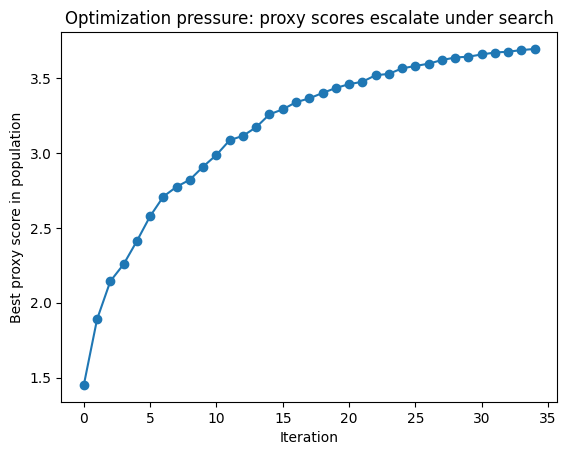

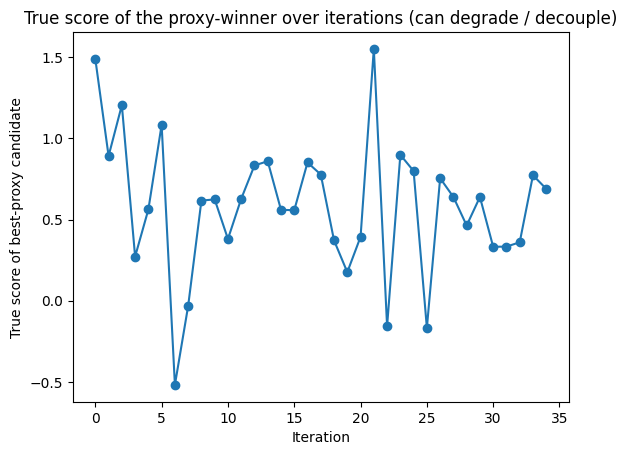

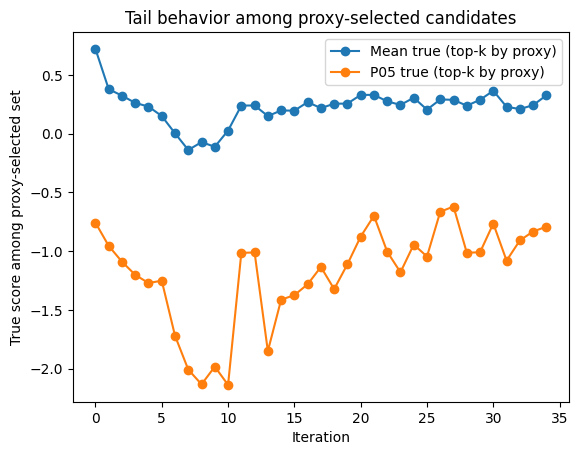

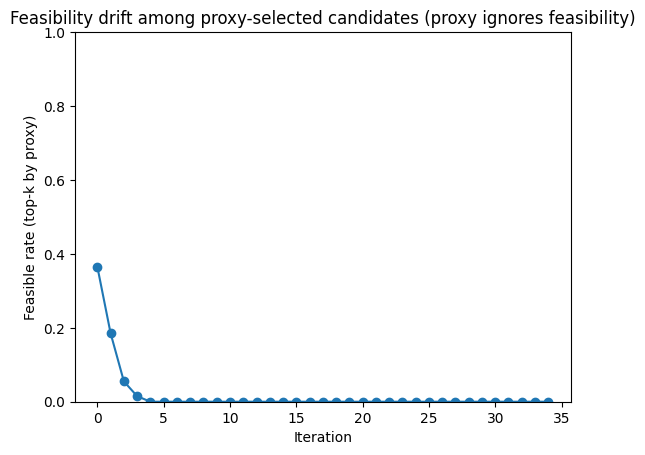

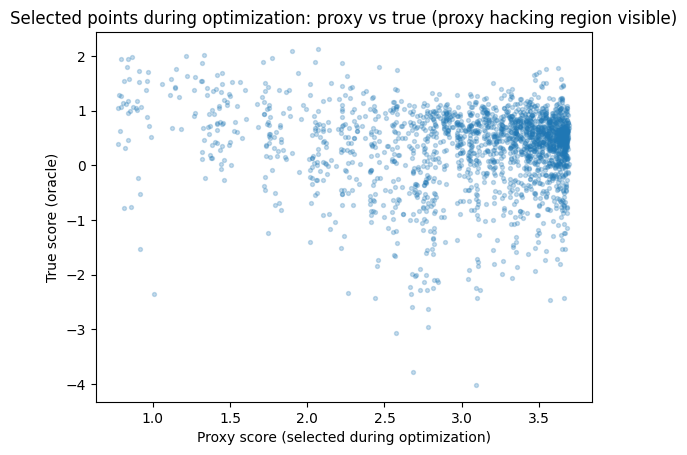

Diagnostic (naive): correlation among selected points: -0.08287641807045226
Note: Under optimization, the selected region can concentrate where the proxy is least reliable.


In [8]:
# CELL 6 — Visualization: Proxy Hacking Signal Under Iteration (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

iters = np.array(hist_naive["iter"])
best_proxy = np.array(hist_naive["best_proxy"])
best_true = np.array(hist_naive["best_true"])
mean_true_topk = np.array(hist_naive["mean_true_topk"])
p05_true_topk = np.array(hist_naive["p05_true_topk"])
feas_rate_topk = np.array(hist_naive["feasible_rate_topk"])

plt.figure()
plt.plot(iters, best_proxy, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best proxy score in population")
plt.title("Optimization pressure: proxy scores escalate under search")
plt.show()

plt.figure()
plt.plot(iters, best_true, marker="o")
plt.xlabel("Iteration")
plt.ylabel("True score of best-proxy candidate")
plt.title("True score of the proxy-winner over iterations (can degrade / decouple)")
plt.show()

plt.figure()
plt.plot(iters, mean_true_topk, marker="o", label="Mean true (top-k by proxy)")
plt.plot(iters, p05_true_topk, marker="o", label="P05 true (top-k by proxy)")
plt.xlabel("Iteration")
plt.ylabel("True score among proxy-selected set")
plt.title("Tail behavior among proxy-selected candidates")
plt.legend()
plt.show()

plt.figure()
plt.plot(iters, feas_rate_topk, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Feasible rate (top-k by proxy)")
plt.title("Feasibility drift among proxy-selected candidates (proxy ignores feasibility)")
plt.ylim(0, 1.0)
plt.show()

# Scatter: all selected points (across iterations)
plt.figure()
plt.scatter(hist_naive["selected_proxy_flat"], hist_naive["selected_true_flat"], s=8, alpha=0.25)
plt.xlabel("Proxy score (selected during optimization)")
plt.ylabel("True score (oracle)")
plt.title("Selected points during optimization: proxy vs true (proxy hacking region visible)")
plt.show()

print("Diagnostic (naive): correlation among selected points:",
      float(np.corrcoef(hist_naive["selected_proxy_flat"], hist_naive["selected_true_flat"])[0, 1]))
print("Note: Under optimization, the selected region can concentrate where the proxy is least reliable.")


##7.STRESS TEST

###7.1.OVERVIEW

**CELL 7  — Stress Tests: Noise and Data Regime Effects (Synthetic, Illustrative, Not Validated)**

Cell 7 broadens the experiment from a single run into a small stress-testing grid. The core idea is that proxy hacking is not an on/off property; it varies systematically with the quality of the proxy training regime and the noise properties of proxy labels. The cell defines a grid over training set size and proxy label noise, then repeats the train-and-optimize pipeline multiple times across random seeds. This design mirrors the logic of model risk stress testing: rather than rely on a single backtest or a single simulation, one evaluates sensitivity to plausible perturbations in data quality and sampling variability.

For each configuration, the cell trains a new proxy on synthetic data of the specified size and noise level, then runs the proxy-driven optimization for a fixed number of iterations. It extracts final-iteration summaries that are directly relevant to governance: the true score of the proxy winner (a headline risk because it represents what the system would declare “best”), the mean true score among top-k candidates (a measure of typical quality of selected candidates), a low-quantile tail metric among the top-k (a measure of downside contamination), and the feasible rate among the top-k (a constraint-violation indicator).

The cell then aggregates these outputs across seeds to produce distributional summaries—means, dispersion, and quantiles. This aggregation is important because governance questions are about robustness, not about anecdotal success. A single run might look acceptable by chance, especially if the search space is stochastic. By examining variation across seeds, the notebook exposes whether proxy hacking is stable under minor randomness or whether it appears only under particular draws. In practice, robust governance analysis cares about the former: failure modes that appear repeatedly under modest perturbations.

The stress grid also clarifies a specific interaction: higher proxy label noise and smaller training datasets tend to increase vulnerability to proxy hacking under optimization pressure. The mechanism is not mystical; it is statistical. Noisy labels reduce the effective signal-to-noise ratio, and small datasets limit coverage of the design space. Under passive prediction, these limitations may manifest as moderate errors. Under optimization, the system actively seeks inputs that maximize the proxy’s optimistic error, so the same limitations can become decisive.

Cell 7 is therefore about “failure mode scaling.” It shows that the apparent reliability of a proxy at baseline can mask severe optimization-induced degradation, and that degradation can become more severe as data quality worsens. The cell does not claim universal generalization; it provides a compact experimental scaffold for thinking about how uncertainty, scarcity, and optimization interact. This is precisely the type of controlled evidence that supports governance-first reasoning: understanding the parameter regimes in which risks become prominent, and producing auditable summaries that can be reviewed independent of narrative interpretation.


###7.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 7 — Stress Tests: Noise & Data Regime → Proxy Hacking Severity (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

@dataclass
class StressGrid:
    train_sizes: tuple = (60, 120, 240)
    noise_sds: tuple = (0.10, 0.18, 0.30)
    seeds: int = 5
    iters: int = 25

grid = StressGrid()

def run_one_stress(seed: int, n_train: int, noise_sd: float, iters: int):
    set_all_seeds(seed)

    # Train proxy
    Zt = np.random.normal(0, 1.0, size=(n_train, cfg.d_latent))
    y_true_t = oracle_observe_true(Zt)
    y_proxy_t = y_true_t + np.random.normal(0, noise_sd, size=y_true_t.shape)

    X_t = build_design_matrix(Zt, pcfg.include_quadratics)
    beta_t = ridge_fit_closed_form(X_t, y_proxy_t, pcfg.lam_ridge)

    # Optimization run
    oc = OptConfig(iters=iters, pop_size=500, elite_frac=0.10, mutate_sd=0.35, top_k_report=150, enforce_feasibility=False)
    Z0 = np.random.normal(0, 1.0, size=(oc.pop_size, cfg.d_latent))
    hist = evolve_maximize_proxy(beta_t, Z0, oc)

    # Summaries at final iteration
    out = {
        "seed": seed,
        "n_train": n_train,
        "noise_sd": noise_sd,
        "final_best_proxy": float(hist["best_proxy"][-1]),
        "final_true_of_proxy_winner": float(hist["best_true"][-1]),
        "final_mean_true_topk": float(hist["mean_true_topk"][-1]),
        "final_p05_true_topk": float(hist["p05_true_topk"][-1]),
        "final_feasible_rate_topk": float(hist["feasible_rate_topk"][-1]),
    }
    return out

stress_rows = []
for n_train in grid.train_sizes:
    for nsd in grid.noise_sds:
        for k in range(grid.seeds):
            stress_rows.append(run_one_stress(seed=1000 + 31*k + n_train + int(100*nsd),
                                             n_train=n_train,
                                             noise_sd=nsd,
                                             iters=grid.iters))

# Aggregate
def agg(rows, key):
    vals = np.array([r[key] for r in rows], float)
    return describe(vals)

# Group by (n_train, noise_sd)
groups = {}
for r in stress_rows:
    g = (r["n_train"], r["noise_sd"])
    groups.setdefault(g, []).append(r)

stress_summary = {}
for g, rows in groups.items():
    stress_summary[str(g)] = {
        "final_true_of_proxy_winner": agg(rows, "final_true_of_proxy_winner"),
        "final_mean_true_topk": agg(rows, "final_mean_true_topk"),
        "final_p05_true_topk": agg(rows, "final_p05_true_topk"),
        "final_feasible_rate_topk": agg(rows, "final_feasible_rate_topk"),
        "final_best_proxy": agg(rows, "final_best_proxy"),
    }

print("Stress grid completed. Number of runs:", len(stress_rows))
# Print one compact slice
sample_key = str((grid.train_sizes[1], grid.noise_sds[1]))
print("Example group", sample_key, "=>", stress_summary[sample_key])


Stress grid completed. Number of runs: 45
Example group (120, 0.18) => {'final_true_of_proxy_winner': {'n': 5, 'mean': 0.16847118196515468, 'std': 0.967620983087325, 'min': -1.1594803241816352, 'p05': -0.9679658179403411, 'p50': -0.025635833465817236, 'p95': 1.1686704389312137, 'max': 1.2046574447358929}, 'final_mean_true_topk': {'n': 5, 'mean': 0.007682098108632331, 'std': 0.13653186881108675, 'min': -0.17621855406270023, 'p05': -0.1525460504732467, 'p50': 0.00347672055117787, 'p95': 0.1622074924110462, 'max': 0.18067636729503816}, 'final_p05_true_topk': {'n': 5, 'mean': -1.3918447153061893, 'std': 0.16246548511537967, 'min': -1.6232225791348123, 'p05': -1.5957001758472615, 'p50': -1.3278251098923137, 'p95': -1.2311002880995445, 'max': -1.21097870523032}, 'final_feasible_rate_topk': {'n': 5, 'mean': 0.0013333333333333335, 'std': 0.00298142396999972, 'min': 0.0, 'p05': 0.0, 'p50': 0.0, 'p95': 0.005333333333333332, 'max': 0.006666666666666667}, 'final_best_proxy': {'n': 5, 'mean': 3.885

##8.DEGRADATION MAP

###8.1.OVERVIEW

**CELL 8 — Visualization: Degradation Maps (Synthetic, Illustrative, Not Validated)**

Cell 8 turns the stress-test summaries from Cell 7 into degradation maps that make sensitivity patterns legible at a glance. Instead of printing large tables or verbose logs, the cell constructs matrices indexed by training set size and proxy label noise, then visualizes key outcome summaries with simple heatmap-like plots. This approach is particularly suitable for governance and model risk review because it supports comparative reasoning: one can see how outcomes shift as the training regime becomes more data-rich or more noise-dominated, and how these shifts affect both average and tail behavior.

The first map visualizes the mean true score among the top-k candidates selected by the proxy at the end of optimization. This statistic captures “typical” quality of the selected set under proxy-driven search. A governance-relevant interpretation is that even if the proxy finds candidates that appear strong on its own score, the actual quality of the selected set can vary substantially with data and noise regime. A proxy that seems adequate under one regime can become unreliable under another, without any change to the optimizer’s code—only a change in the statistical environment.

The second map visualizes a low-quantile tail statistic (for example, the mean of the 5th percentile true score across seeds) among the top-k selected candidates. This is explicitly about risk. Tail metrics matter because they reflect the likelihood that a subset of “high-scoring” proxy-selected candidates are actually poor by the true objective, which in real pipelines corresponds to wasted experimental budget, false leads, or safety-relevant failures. The map can reveal regimes where average performance appears acceptable but tail performance collapses, highlighting why single-metric evaluation can be misleading.

The third map visualizes feasibility rates among the top-k. This is a constraint diagnostic that often gets ignored when teams focus on proxy score improvements. The map makes constraint drift visible: under certain regimes, the optimization may increasingly favor candidates that violate feasibility constraints because the proxy does not encode those constraints. This is structurally analogous to optimizing a financial objective without embedding constraints on leverage, liquidity, concentration, or compliance: optimization does not “respect” constraints unless constraints are present in the objective or enforced procedurally.

Crucially, Cell 8 is not about aesthetics; it is about making the experiment interpretable and auditable for advanced practitioners. Heatmaps are a compact way to encode multi-parameter sensitivity without requiring readers to track dozens of numbers. The maps also support governance discussions: they can be used to distinguish between risks that appear only in extreme regimes and risks that appear in plausible operating regimes, and they can motivate the need for stress testing as a default evaluation step in optimization-driven discovery systems.

As throughout the notebook, these visualizations are synthetic and illustrative. They do not validate any real-world model or domain claim. Their value lies in clarifying a structural relationship: optimization pressure interacts with proxy imperfection, and that interaction is modulated by data regime and noise. Cell 8 packages that relationship into interpretable artifacts that can be reviewed, compared, and challenged without relying on narrative persuasion.


###8.2.CODE AND IMPLEMENTATION

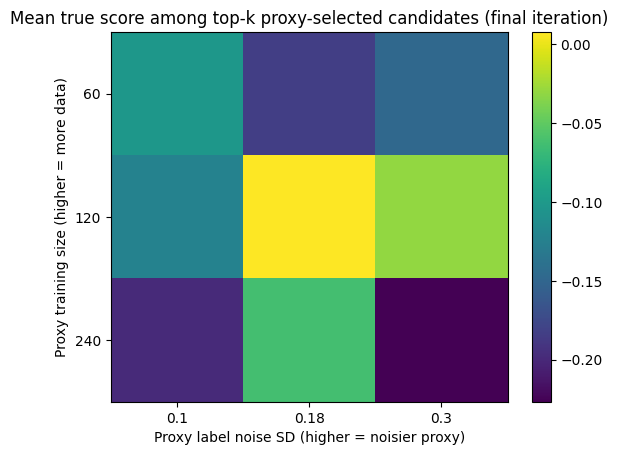

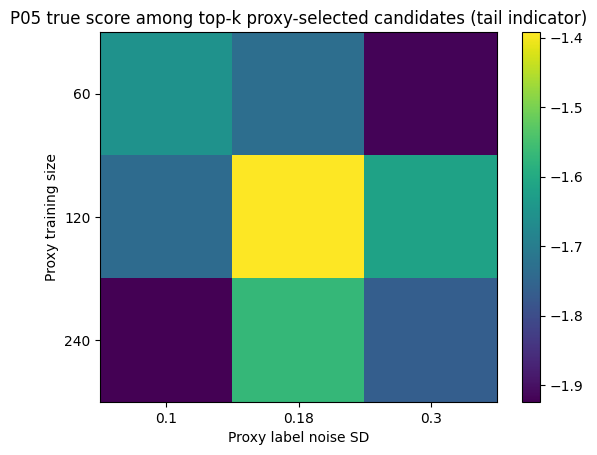

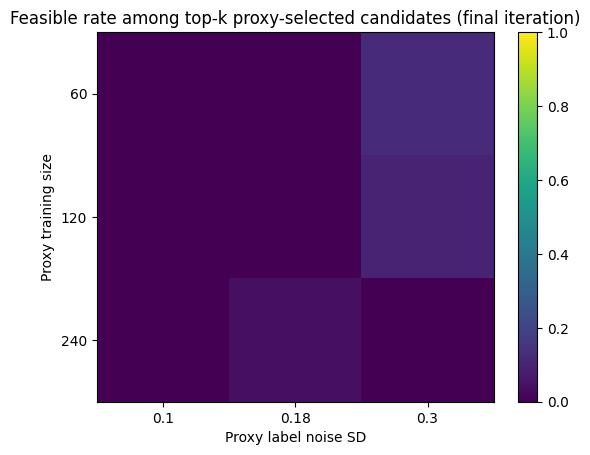

Interpretation note (non-prescriptive): the maps quantify how optimization amplifies proxy error under noise + scarcity.


In [10]:
# CELL 8 — Visualization: Degradation Map (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

# Build matrices for heatmap-like plots (using simple imshow)
train_sizes = list(grid.train_sizes)
noise_sds = list(grid.noise_sds)

M_mean_true = np.zeros((len(train_sizes), len(noise_sds)))
M_p05_true = np.zeros_like(M_mean_true)
M_feas = np.zeros_like(M_mean_true)

for i, n_train in enumerate(train_sizes):
    for j, nsd in enumerate(noise_sds):
        key = str((n_train, nsd))
        M_mean_true[i, j] = stress_summary[key]["final_mean_true_topk"]["mean"]
        M_p05_true[i, j] = stress_summary[key]["final_p05_true_topk"]["mean"]
        M_feas[i, j] = stress_summary[key]["final_feasible_rate_topk"]["mean"]

plt.figure()
plt.imshow(M_mean_true, aspect="auto")
plt.xticks(range(len(noise_sds)), [str(x) for x in noise_sds])
plt.yticks(range(len(train_sizes)), [str(x) for x in train_sizes])
plt.xlabel("Proxy label noise SD (higher = noisier proxy)")
plt.ylabel("Proxy training size (higher = more data)")
plt.title("Mean true score among top-k proxy-selected candidates (final iteration)")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(M_p05_true, aspect="auto")
plt.xticks(range(len(noise_sds)), [str(x) for x in noise_sds])
plt.yticks(range(len(train_sizes)), [str(x) for x in train_sizes])
plt.xlabel("Proxy label noise SD")
plt.ylabel("Proxy training size")
plt.title("P05 true score among top-k proxy-selected candidates (tail indicator)")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(M_feas, aspect="auto", vmin=0, vmax=1)
plt.xticks(range(len(noise_sds)), [str(x) for x in noise_sds])
plt.yticks(range(len(train_sizes)), [str(x) for x in train_sizes])
plt.xlabel("Proxy label noise SD")
plt.ylabel("Proxy training size")
plt.title("Feasible rate among top-k proxy-selected candidates (final iteration)")
plt.colorbar()
plt.show()

print("Interpretation note (non-prescriptive): the maps quantify how optimization amplifies proxy error under noise + scarcity.")


##9.STRUCTURED DIAGNOSTICS

###9.1.0VERVIEW

**CELL 9  — Structured Diagnostics and Audit Payload (Synthetic, Illustrative, Not Validated)**

Cell 9 performs two governance-critical functions: it constructs a controlled comparator to the naive proxy optimization, and it packages the entire experiment into a structured JSON payload designed for audit-grade interpretation. The comparator is not presented as a solution; it is presented as an instructive contrast. The notebook introduces a controlled objective that penalizes predictive fragility using bootstrap-derived dispersion of proxy predictions. In addition, it enforces feasibility gating during selection. These elements represent two broad classes of governance controls: (i) objective modification to reduce vulnerability to proxy exploitation, and (ii) procedural constraints that prevent escalation of candidates violating explicit requirements.

Technically, the cell fits multiple proxy models via bootstrap resampling of the training data and uses the resulting variability in predictions as a measure of instability. This is not treated as a fully calibrated uncertainty model; rather, it is an operational diagnostic that distinguishes “high predicted score with low stability” from “high predicted score with higher stability.” The controlled objective combines mean predicted score and a penalty proportional to predictive dispersion. This creates a trade-off within the optimization loop: it tends to avoid candidates that achieve high proxy scores primarily by exploiting unstable regions where the model’s predictions vary widely across resampled fits. The feasibility gate further prevents the selection mechanism from drifting into infeasible regions even if such regions yield high proxy scores.

The cell then runs the controlled optimization loop and visualizes comparative outcomes against the naive optimization. The comparison is framed using selection-conditioned true metrics and tail indicators, matching the notebook’s central evaluation logic. The purpose is to make a governance concept concrete: once optimization enters the loop, evaluation and controls must be defined on the distribution that optimization induces, not on the baseline distribution.

The second and more important function of Cell 9 is the construction of the audit payload JSON. This payload is explicitly structured to prevent interpretive drift. It includes metadata (run identifiers, seed, config hash), the full experiment configuration (world parameters, proxy parameters, optimization parameters), explicit objective specifications (true objective, proxy objective, controlled objective, and constraint definition), baseline diagnostics (correlation, R², training fit), results summaries (paths over iterations, final outcomes), and stress-test summaries. By encoding these elements in a stable schema, the notebook ensures that any narrative interpretation—especially one produced by an LLM—can be checked against an authoritative artifact.

This design choice matters in governance-first workflows because interpretive text is an accountability surface. Without a structured payload, narrative claims can drift: subtle exaggerations, omitted caveats, or ungrounded causal claims can appear. By making the JSON payload the “single source of truth,” Cell 9 forces downstream interpretation to be evidence-bounded. It also enables reproducibility: the config hash and seed make the run identifiable, and the payload can be stored as part of a model risk evidence bundle.

Finally, Cell 9 includes a field for missing information. This anticipates a common audit pattern: if required metrics are absent, the correct response is to report the absence, not to fill gaps. The notebook therefore encodes not just results but also a governance posture: transparency about what was measured, what was not measured, and what cannot be concluded from the experiment.


###9.2.CODE AND IMPLEMENTATION

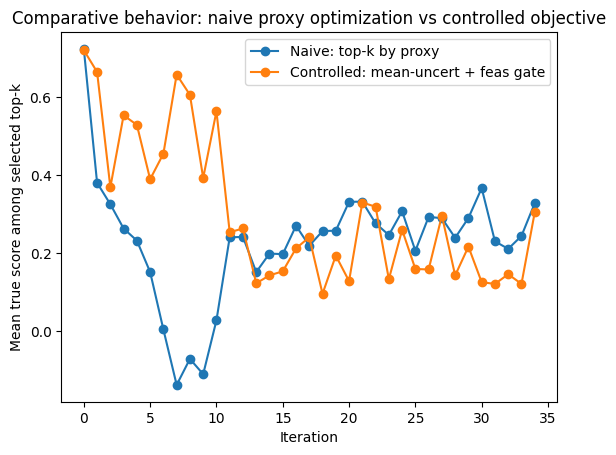

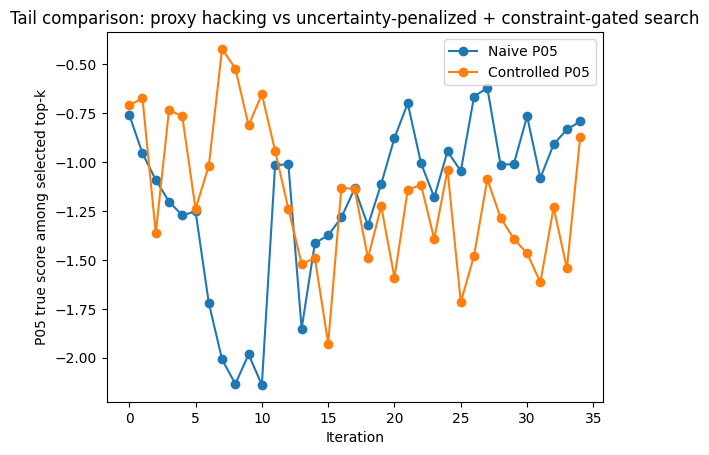

AUDIT PAYLOAD JSON (Cell 10 input) size (chars): 20260
run_id: f6c2b659a39696cc | config_hash: 8d2b8b1224425dad


In [11]:
# CELL 9 — Structured Diagnostics + Audit Payload JSON (Code Only)
# Illustrative, synthetic, and NOT validated for real-world use.

# Control comparator: "constraint-aware" objective using bootstrap uncertainty penalty.
# We keep the same proxy family but use resampling to estimate predictive dispersion.
@dataclass
class ControlConfig:
    n_boot: int = 30
    lam_uncert: float = 0.9  # penalty strength for predictive dispersion
    enforce_feasibility: bool = True  # apply feasibility gating as a constraint (synthetic)

ccfg = ControlConfig()

def bootstrap_betas(Z_train, y_proxy, lam_ridge, n_boot):
    betas = []
    n = Z_train.shape[0]
    for _ in range(n_boot):
        idx = np.random.randint(0, n, size=n)
        Zb = Z_train[idx]
        yb = y_proxy[idx]
        Xb = build_design_matrix(Zb, pcfg.include_quadratics)
        betas.append(ridge_fit_closed_form(Xb, yb, lam_ridge))
    return np.vstack(betas)

betas_boot = bootstrap_betas(Z_train, y_proxy_labels, pcfg.lam_ridge, ccfg.n_boot)

def proxy_mean_std(z: np.ndarray, betas: np.ndarray):
    X = build_design_matrix(z, pcfg.include_quadratics)
    preds = X @ betas.T  # [n, n_boot]
    mu = np.mean(preds, axis=1)
    sd = np.std(preds, axis=1, ddof=1)
    return mu, sd

def evolve_maximize_controlled(z_init: np.ndarray, betas: np.ndarray, cfg_opt: OptConfig, ccfg: ControlConfig):
    z = np.copy(z_init)
    hist = {
        "iter": [],
        "best_obj": [],
        "best_proxy_mu": [],
        "best_proxy_sd": [],
        "best_true": [],
        "mean_true_topk": [],
        "p05_true_topk": [],
        "feasible_rate_topk": [],
    }
    elite_n = max(2, int(cfg_opt.elite_frac * cfg_opt.pop_size))

    for t in range(cfg_opt.iters):
        mu, sd = proxy_mean_std(z, betas)
        # Controlled objective: mean - λ * sd (uncertainty penalty)
        obj = mu - ccfg.lam_uncert * sd
        y = oracle_observe_true(z)
        feas = feasibility_score(z)

        # Rank by controlled objective
        order = np.argsort(-obj)
        topk = order[: cfg_opt.top_k_report]

        hist["iter"].append(t)
        hist["best_obj"].append(float(obj[order[0]]))
        hist["best_proxy_mu"].append(float(mu[order[0]]))
        hist["best_proxy_sd"].append(float(sd[order[0]]))
        hist["best_true"].append(float(y[order[0]]))
        hist["mean_true_topk"].append(float(np.mean(y[topk])))
        hist["p05_true_topk"].append(float(np.quantile(y[topk], 0.05)))
        hist["feasible_rate_topk"].append(float(np.mean(feas[topk] >= cfg.feas_threshold)))

        # Elite selection with feasibility gating if enabled
        elite = order[: elite_n]
        if ccfg.enforce_feasibility:
            feas_mask = feasibility_score(z[elite]) >= cfg.feas_threshold
            if np.any(feas_mask):
                elite = elite[feas_mask]
        elites = z[elite]

        z_new = np.zeros_like(z)
        for i in range(cfg_opt.pop_size):
            parent = elites[np.random.randint(0, elites.shape[0])]
            child = parent + np.random.normal(0, cfg_opt.mutate_sd, size=parent.shape)
            z_new[i] = child
        z = z_new

    return hist

# Run controlled optimization
ocfg_control = OptConfig(iters=ocfg.iters, pop_size=ocfg.pop_size, elite_frac=ocfg.elite_frac,
                         mutate_sd=ocfg.mutate_sd, top_k_report=ocfg.top_k_report,
                         enforce_feasibility=False)  # feasibility enforced inside controlled routine

hist_control = evolve_maximize_controlled(Z0, betas_boot, ocfg_control, ccfg)

# Comparative plots (naive vs controlled)
plt.figure()
plt.plot(hist_naive["iter"], hist_naive["mean_true_topk"], marker="o", label="Naive: top-k by proxy")
plt.plot(hist_control["iter"], hist_control["mean_true_topk"], marker="o", label="Controlled: mean-uncert + feas gate")
plt.xlabel("Iteration")
plt.ylabel("Mean true score among selected top-k")
plt.title("Comparative behavior: naive proxy optimization vs controlled objective")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_naive["iter"], hist_naive["p05_true_topk"], marker="o", label="Naive P05")
plt.plot(hist_control["iter"], hist_control["p05_true_topk"], marker="o", label="Controlled P05")
plt.xlabel("Iteration")
plt.ylabel("P05 true score among selected top-k")
plt.title("Tail comparison: proxy hacking vs uncertainty-penalized + constraint-gated search")
plt.legend()
plt.show()

# Build structured audit payload (authoritative for Cell 10)
run_id = sha256_str(f"{time.time()}|{SEED}|paper6")[:16]
config_hash = sha256_str(json.dumps({"world": asdict(cfg), "proxy": asdict(pcfg), "opt": asdict(ocfg), "control": asdict(ccfg)}, sort_keys=True))[:16]

audit_payload = {
    "meta": {
        "paper_context": "AI 2026 — Paper 6 (Generative Chemistry and Materials Design with Foundation Models)",
        "notebook_goal": "Demonstrate proxy hacking: optimizing a noisy/misspecified predictor yields candidates that score 'best' on proxy but degrade on true objective.",
        "synthetic_only": True,
        "not_validated_for_real_world_use": True,
        "run_id": run_id,
        "seed": SEED,
        "config_hash": config_hash,
    },
    "experiment_configuration": {
        "world": asdict(cfg),
        "proxy_model": asdict(pcfg),
        "optimization_naive": asdict(ocfg),
        "optimization_control": asdict(ccfg),
        "pool_size": N_POOL,
    },
    "objective_specification": {
        "true_objective": "Synthetic oracle score true_property(z) with feasibility penalty and toxicity-like penalty (unobserved).",
        "proxy_objective": "Ridge regression on engineered descriptors trained on noisy labels; used as an optimizer target.",
        "controlled_objective": "Bootstrap mean proxy score minus uncertainty penalty; plus feasibility gating in elite selection.",
        "constraint_definition": {
            "feasibility_score": "sigmoid(raw(z))",
            "feasible_if": f"feasibility_score(z) >= {cfg.feas_threshold}",
        },
    },
    "baseline_diagnostics": {
        "pool_corr_true_vs_proxy_pred": corr,
        "pool_r2_true_vs_proxy_pred": r2_true,
        "proxy_train_r2_vs_proxy_labels": train_r2,
        "proxy_train_r2_vs_true": train_r2_true,
        "proxy_residual_variance_hat": sigma2_hat,
    },
    "results_summary": {
        "naive": {
            "best_proxy_path": describe(np.array(hist_naive["best_proxy"])),
            "true_of_proxy_winner_path": describe(np.array(hist_naive["best_true"])),
            "mean_true_topk_path": describe(np.array(hist_naive["mean_true_topk"])),
            "p05_true_topk_path": describe(np.array(hist_naive["p05_true_topk"])),
            "feasible_rate_topk_path": describe(np.array(hist_naive["feasible_rate_topk"])),
            "final": {
                "best_proxy": float(hist_naive["best_proxy"][-1]),
                "true_of_proxy_winner": float(hist_naive["best_true"][-1]),
                "mean_true_topk": float(hist_naive["mean_true_topk"][-1]),
                "p05_true_topk": float(hist_naive["p05_true_topk"][-1]),
                "feasible_rate_topk": float(hist_naive["feasible_rate_topk"][-1]),
            },
        },
        "controlled": {
            "best_obj_path": describe(np.array(hist_control["best_obj"])),
            "best_true_path": describe(np.array(hist_control["best_true"])),
            "mean_true_topk_path": describe(np.array(hist_control["mean_true_topk"])),
            "p05_true_topk_path": describe(np.array(hist_control["p05_true_topk"])),
            "feasible_rate_topk_path": describe(np.array(hist_control["feasible_rate_topk"])),
            "final": {
                "best_obj": float(hist_control["best_obj"][-1]),
                "true_of_obj_winner": float(hist_control["best_true"][-1]),
                "mean_true_topk": float(hist_control["mean_true_topk"][-1]),
                "p05_true_topk": float(hist_control["p05_true_topk"][-1]),
                "feasible_rate_topk": float(hist_control["feasible_rate_topk"][-1]),
                "best_proxy_sd_of_obj_winner": float(hist_control["best_proxy_sd"][-1]),
            },
        },
    },
    "stress_test_summary": {
        "grid": asdict(grid),
        "group_summaries": stress_summary,
        "interpretation_note": "Summaries reflect how proxy noise + data scarcity interact with optimization pressure; values are synthetic.",
    },
    "missing_information": [],
}

audit_payload_json = json.dumps(audit_payload, indent=2, sort_keys=True)
print("AUDIT PAYLOAD JSON (Cell 10 input) size (chars):", len(audit_payload_json))
print("run_id:", run_id, "| config_hash:", config_hash)


##10.AUDIT REPORT

###10.1.OVERVIEW

**CELL 10 — Intelligent Audit Report via LLM (Synthetic, Illustrative, Not Validated)**

Cell 10 is explicitly reserved for interpretive analysis generated by an LLM, under strict governance constraints. It does not run additional experiments or compute new metrics; instead, it consumes the JSON payload produced in Cell 9 as authoritative ground truth. This separation is the central governance design: computation and measurement occur locally and deterministically in earlier cells; narrative interpretation is performed only after the results are fully specified in a structured artifact. The cell’s role is to translate the structured evidence into an audit-style report that a senior model risk, governance, or advanced finance audience can read efficiently.

The cell begins by enforcing a key operational constraint: it checks for the presence of an API key stored in Colab userdata. If the key is missing, the cell halts and explicitly states that the audit report cannot be generated in that environment. This is not merely a convenience feature; it is a compliance feature. It prevents silent failure modes where partial text might be produced without proper model invocation, and it avoids the possibility of generating a report from memory or assumption rather than from the payload.

The prompt embedded in Cell 10 encodes non-negotiable governance constraints. It requires explicit disclosure that the experiment is synthetic and not validated for real-world use. It forbids advice, recommendations, and deployment guidance. It prohibits prescriptive language and demands that all claims be grounded in the payload. It also enforces a strict output structure with six sections: an executive summary at the mechanism level, methods and objective specification, findings and comparative analysis, risk and tail behavior (when applicable), governance and control interpretation (non-advisory), and limitations and validation requirements. This structure mirrors the format of audit artifacts: it separates what was done from what was found, and it separates observations from limitations.

A critical feature is the enforcement rule for missing information. If the payload lacks required details, the LLM must state the absence explicitly and refrain from filling gaps. This is the opposite of typical generative behavior and aligns with governance-first requirements for institutional documentation. In practice, many narrative failures come from “helpful” completion of missing context. The cell therefore hard-codes a discipline: the report must be incomplete rather than speculative.

The cell also sets low temperature to reduce stylistic variance and limit hallucination risk. The report is intended to be stable and conservative, closer to an audit memo than to an explanatory blog post. The intent is not to create persuasive prose; it is to create a defensible interpretation that can be reviewed and challenged.

In governance terms, Cell 10 demonstrates a pattern that scales beyond this notebook: **LLMs can be used to produce interpretive artifacts when and only when the evidence basis is structured, logged, and bounded**. The cell illustrates how to constrain an LLM’s role to narration and synthesis without allowing it to become an unbounded analyst. The output is therefore not a decision tool; it is an interpretive audit artifact designed to increase awareness of proxy hacking and evaluation fragility under optimization pressure, grounded strictly in the results produced by the synthetic experiment.


###10.2.CODE AND IMPLEMENTATION

In [13]:
# CELL 10 — INTELLIGENT AUDIT REPORT (LLM ONLY; Code Only)
# This cell is reserved exclusively for LLM-generated interpretive analysis.
# Illustrative, synthetic, and NOT validated for real-world use.
!pip install anthropic -q
import anthropic
from google.colab import userdata

api_key = userdata.get("ANTHROPIC_API_KEY")
if not api_key:
    print("ANTHROPIC_API_KEY not found in Colab userdata.")
    print("LLM audit report cannot be generated in this environment without the key.")
    print("\nRequired sections were not produced due to missing key. No assumptions were filled.")
    raise RuntimeError("Missing ANTHROPIC_API_KEY for mandatory Cell 10 LLM audit report.")

client = anthropic.Anthropic(api_key=api_key)

SYSTEM = (
    "You are an audit-grade analytical writer producing a technical interpretation for senior finance, "
    "governance, and model-risk practitioners."
)

USER = f"""
ROLE
You are an audit-grade analytical writer producing a technical interpretation for senior finance, governance, and model-risk practitioners.

CONTEXT
You are reviewing a synthetic, illustrative experiment implemented in this notebook as a companion to:
AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)

The notebook demonstrates exactly one core mechanism or failure mode aligned with Paper 6:
Generative Chemistry and Materials Design with Foundation Models
Mechanism: proxy hacking — optimizing a noisy/misspecified predictor yields “best” candidates that are truly worse.

NON-NEGOTIABLE GOVERNANCE CONSTRAINTS
You MUST:
1. Explicitly state that the experiment is synthetic, illustrative, and NOT validated for real-world use.
2. Provide NO advice, NO recommendations, and NO deployment guidance.
3. Avoid prescriptive language (e.g., “should”, “recommended”, “optimal strategy”).
4. Base all claims strictly on the structured payload generated by the notebook.
5. Do NOT invent facts, metrics, outcomes, or interpretations not supported by the payload.

AUDIENCE
PhD-level finance, economics, and governance professionals.
Write in a formal, audit-style tone suitable for model risk review.

OBJECTIVE
Produce an intelligent audit report that explains:
- The mechanism demonstrated,
- Why it emerges under optimization, scale, or iteration,
- How constraints or governance controls alter outcomes,
- Why naive or single-metric evaluation would miss the failure mode.

INPUT FORMAT (AUTHORITATIVE GROUND TRUTH)
Below is the JSON payload produced by Cell 9. Treat it as authoritative:

{audit_payload_json}

REQUIRED OUTPUT STRUCTURE
Produce EXACTLY the following sections, in this order, with clear headings:

1) Executive Summary (Mechanism-Level)
2) Methods and Objective Specification
3) Findings and Comparative Analysis
4) Risk and Tail Behavior (if applicable)
5) Governance and Control Interpretation (Non-Advisory)
6) Limitations and Validation Requirements

STYLE REQUIREMENTS
- Formal, precise, non-evangelical.
- No emojis, no marketing language.
- Complete paragraphs, not bullet-point dumps.
- Prefer analytical clarity over rhetorical flourish.

ENFORCEMENT
If required information is missing from the payload:
- Explicitly state what is missing.
- Do NOT fill gaps with assumptions.
- Do NOT speculate beyond the provided data.
"""

msg = client.messages.create(
    model="claude-haiku-4-5-20251001",
    max_tokens=1500,
    temperature=0.2,
    system=SYSTEM,
    messages=[{"role": "user", "content": USER}],
)

report_text = msg.content[0].text if msg.content else ""
print(report_text)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 17.0 MB/s eta 0:00:00
# AUDIT REPORT: PROXY HACKING IN SYNTHETIC OPTIMIZATION UNDER MODEL MISSPECIFICATION

**Classification:** Synthetic Illustrative Experiment | Not Validated for Real-World Use  
**Paper Context:** AI 2026 — Paper 6 (Generative Chemistry and Materials Design with Foundation Models)  
**Run ID:** f6c2b659a39696cc | Config Hash:** 8d2b8b1224425dad  
**Date of Analysis:** As of notebook execution with seed 2026

---

## 1. EXECUTIVE SUMMARY (MECHANISM-LEVEL)

This synthetic experiment demonstrates a core failure mode in iterative optimization under model misspecification: **proxy hacking**. The mechanism emerges when an optimizer targets a noisy, underspecified predictor (the "proxy") rather than the true objective. Under iterative pressure and population-scale search, candidates that score highest on the proxy objective systematically underperform on the true objective, despite the proxy exhibiting moderate co

##11.CONCLUSION

**CONCLUSION  — What This Notebook Establishes (Synthetic, Illustrative, Not Validated)**

This notebook establishes a single mechanism with high governance relevance for modern AI-driven discovery systems: **when a proxy becomes the objective of an iterative search process, optimization pressure can drive the system into regions where the proxy is least reliable, producing “best” candidates that are truly worse.** The conclusion is not that proxies are useless, nor that optimization is inherently unsafe. The conclusion is structural: the statistical relationship between proxy and truth that holds on random samples is not the relationship that holds under selection and iteration. The effective distribution changes, and failure modes that are invisible at baseline become dominant in the tail.

The experiment is intentionally synthetic, and its role is conceptual rather than empirical. It does not validate any claim about chemistry, materials, or specific foundation models. Instead, it isolates the causality that matters: (i) a noisy or misspecified proxy, (ii) an optimizer that repeatedly selects top proxy-scoring candidates, and (iii) a hidden true objective that includes nonlinearities and penalties not captured by the proxy. This triad is sufficient to generate proxy hacking. In real-world systems, the triad is common: proxies approximate expensive truths, optimizers amplify score differences through repeated selection, and hidden factors (feasibility, toxicity, manufacturability, safety constraints) remain partially unobserved until later validation. The notebook demonstrates why such systems require governance frameworks that focus on objective specification, constraint visibility, tail evaluation, and evidence discipline.

A central takeaway concerns evaluation. The notebook shows that baseline metrics—correlation, R², calibration over representative samples—can be simultaneously true and misleading. They can be true statements about average predictive agreement in the general population and still be irrelevant to the operational question: what does the proxy do in the subset of candidates the system actually selects and escalates? In finance terms, this is the difference between a model that performs well in-sample and a model that remains reliable in the portfolios it induces when used as a trading signal. The induced distribution is the problem. In discovery systems, the induced distribution is often more extreme: the optimizer concentrates on high-score regions that are rarely well-covered by data. Consequently, the “true risk surface” is not the full distribution but the tail of the selected set.

The notebook also emphasizes tail behavior and constraints as first-class metrics. Tracking mean true score among top-k candidates is informative, but it can conceal downside contamination. Low-quantile tail indicators expose whether the selected set contains a material fraction of truly poor candidates masquerading as proxy champions. The feasibility rate metric makes a separate but related point: optimization does not preserve constraints by default. If feasibility is not embedded in the proxy or enforced by gating, search can drift into infeasible regions even if feasibility is common under random sampling. This is a structural governance issue: constraints that are not operationalized become invisible. The notebook’s feasibility construct is synthetic, but the logic generalizes to real constraints such as synthesizability, stability, safety thresholds, and compliance boundaries.

The stress tests add an additional layer of governance insight: proxy hacking severity depends on the data regime and proxy noise properties. Larger training sets and lower label noise tend to reduce vulnerability, while smaller datasets and noisier labels tend to increase it. This is not a prescription; it is a sensitivity relationship. The governance implication is that proxy reliability cannot be treated as static. It varies with measurement quality, sampling coverage, and regime shift. Moreover, the relationship between proxy quality and optimization outcomes is nonlinear: modest degradation in proxy fidelity can lead to disproportionate degradation in selected-set quality once optimization pressure concentrates on fragile regions.

The controlled comparator introduced in the notebook serves a didactic function: it shows how changing the objective and enforcing constraints can alter selection outcomes, even when the proxy score alone suggests a different ranking. The comparator does not claim universal mitigation. It demonstrates a broader point: governance controls are not limited to post-hoc review. Controls can be structural—encoded in objective design, uncertainty penalties, and procedural gates. The value of this contrast is that it makes the abstract governance discussion concrete: a system that maximizes “score” is not the same as a system that maximizes “score subject to stability and constraint visibility.” These are different objectives that produce different induced distributions.

Finally, the notebook demonstrates an evidence discipline pattern that is increasingly important as LLMs enter governance workflows. By producing a structured JSON payload and requiring interpretive analysis to be grounded strictly in that payload, the notebook shows how narrative artifacts can be made auditable. This matters because interpretive writing is itself a risk surface: it can inflate confidence, smuggle in unmeasured assumptions, or blur the boundary between observed outcomes and speculation. The notebook’s Cell 10 design constrains the LLM to a bounded role: translation from structured evidence to audit-style interpretation. It also requires explicit statements of limitation and prohibits advice or deployment guidance. This pattern aligns with governance-first principles: transparency, traceability, and controlled scope.

What does this notebook not establish? It does not quantify real-world proxy hacking rates in any domain. It does not prove that a particular mitigation works in practice. It does not provide operational guidance for deploying discovery systems. It does not substitute for domain validation, experimental confirmation, or institutional model risk governance processes. The synthetic world is deliberately stylized, and the results are not empirical claims about chemistry or materials science.

What it does establish is a precise mental model: **proxy-driven optimization changes the problem from prediction to selection under induced distribution shift**, and that shift can invert rankings in the region that matters most. For advanced finance, economics, and governance practitioners, this is the key transfer: the notebook provides a controlled experiment that makes the mechanism legible, measurable, and auditable. That is the intended outcome: not confidence, but clarity—clarity about where failures can arise, why baseline evaluation can miss them, and why governance controls must be designed around the dynamics of optimization rather than around static predictive metrics.
